In [4]:
#Get metadata from CaltechDATA

import os
from ames.harvesters import get_caltechdata

if os.path.isdir('data') == False:
    os.mkdir('data')
os.chdir('data')

production = True
collection = 'caltechdata.ds'

get_caltechdata(collection,production)

 25% (252 of 993) |#####                 | Elapsed Time: 0:00:00 ETA:   0:00:01

Author identifiers not an array - please check 10.14291/tccon.ggg2014.izana01.R0/1149295
Author identifiers not an array - please check 10.14291/tccon.ggg2014.izana01.R0/1149295


100% (993 of 993) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


Gathering data!


/Users/tmorrell/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:80: UserWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


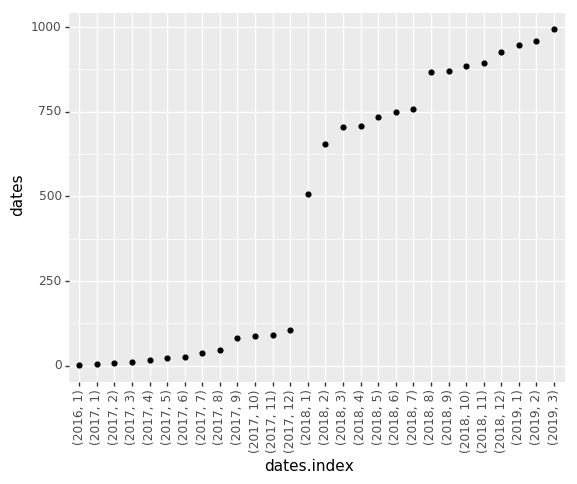

<ggplot: (7548548167)>

In [43]:
#Collect submissions over time
%matplotlib inline
from ames.harvesters import get_records
import dataset
import pandas as pd
import plotnine as p9
dot_paths = ['._Key','.dates','.resourceType','.subjects']
keys = dataset.keys(collection)
all_metadata = get_records(dot_paths,'dois',collection,keys)
dates = []
for record in all_metadata:
    #Issued date type takes precedence, otherwise Submitted date
    rdate = None
    for date in record['dates']:
        if date['dateType']=='Issued':
            rdate = date['date']
        if date['dateType']=='Submitted':
            if rdate == None:
                rdate = date['date']
    dates.append(rdate)
frame = pd.DataFrame(data=dates,dtype='datetime64',columns=['dates'])
date_frame = frame.groupby([frame["dates"].dt.year, frame["dates"].dt.month]).count()
p9.ggplot(date_frame.cumsum(), p9.aes(x='dates.index',y='dates')) + p9.geom_line() + p9.geom_point() + p9.theme(axis_text_x = p9.element_text(angle=90))